In [1]:
############################################################
# 0) SETUP ENVIRONMENT
############################################################

!pip install -q gdown facenet-pytorch timm pillow-heif scikit-learn opencv-python tqdm

from pillow_heif import register_heif_opener
register_heif_opener()

import os, shutil, zipfile, cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
import timm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


############################################################
# Extra imports for CNN & ViT training
############################################################
import random
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


Using device: cuda


In [2]:
############################################################
# 1) DOWNLOAD + EXTRACT DATASET
############################################################

import gdown

file_id = "1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO"
url = f"https://drive.google.com/uc?id={file_id}"

data_dir = Path("dataset")
data_dir.mkdir(exist_ok=True)
zip_path = data_dir / "dataset.zip"

if not zip_path.exists():
    gdown.download(url, str(zip_path), quiet=False)

extract_path = data_dir / "raw"
if not extract_path.exists():
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Downloading...
From (original): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO
From (redirected): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO&confirm=t&uuid=e6bd4cd6-d3d8-4cd6-855c-edd165850cd0
To: /content/dataset/dataset.zip
100%|██████████| 428M/428M [00:05<00:00, 73.4MB/s]


Dataset extracted to: dataset/raw


In [3]:
# ================================================
# CLEANER & FORMAT NORMALIZATION FIX
# ================================================

import shutil, zipfile, os
from pathlib import Path
from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener()

print("=== STARTING DATA CLEANING ===")

# --- SETTINGS ---
file_id = "1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO"
url = f"https://drive.google.com/uc?id={file_id}"

valid_ext = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}

# --- BASE FOLDER ---
data_dir = Path("dataset")
data_dir.mkdir(exist_ok=True)
zip_path = data_dir/"dataset.zip"

# --- DOWNLOAD IF NEEDED ---
if not zip_path.exists():
    import gdown
    gdown.download(url, str(zip_path), quiet=False)

# --- EXTRACT IF NEEDED ---
extract_root = data_dir/"raw"
if not extract_root.exists():
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_root)

print("Extracted structure:")
for p in extract_root.iterdir():
    print(" -", p)

# =====================================================
# FIX NESTED "Train/Train" CASE — FLATTEN STRUCTURE
# =====================================================

def flatten_nested_train(root):
    """Jika ada folder Train/Train/NAMA_ORANG → pindahkan ke Train/NAMA_ORANG"""
    nested = list(root.rglob("Train/Train"))
    for t in nested:
        print("[FIX] Found nested Train folder →", t)

        parent_correct = t.parent  # first Train folder
        for person in t.iterdir():
            if person.is_dir():
                dest = parent_correct/person.name
                dest.mkdir(exist_ok=True)
                for f in person.iterdir():
                    shutil.move(str(f), str(dest))
            person.unlink(missing_ok=True)

        shutil.rmtree(t, ignore_errors=True)

# Detect main train folder
train_candidates = [p for p in extract_root.rglob("*") if p.is_dir() and p.name.lower()=="train"]
if train_candidates:
    main_train = train_candidates[0]
    flatten_nested_train(main_train)
else:
    raise RuntimeError("Train folder tidak ditemukan.")

# =====================================================
# CLEAN FOLDER: REMOVE .DS_Store & CONVERT NON-JPG
# =====================================================

def convert_to_jpg(path):
    """Convert format apapun (HEIC/JFIF) → JPG"""
    try:
        img = Image.open(path).convert("RGB")
        new_path = path.with_suffix(".jpg")
        img.save(new_path, "JPEG", quality=95)
        path.unlink()
        print("[CONVERT]", path.name, "→", new_path.name)
        return new_path
    except:
        print("[REMOVE CORRUPT]", path)
        try: path.unlink()
        except: pass
        return None

clean_count = 0
removed = 0

for item in main_train.rglob("*"):
    # Skip folder
    if item.is_dir():
        continue

    # Remove useless meta files
    if item.name.startswith(".") or item.name.lower() == "thumbs.db":
        print("[DELETE META]", item)
        item.unlink(missing_ok=True)
        removed += 1
        continue

    # Convert weird format
    if item.suffix.lower() not in valid_ext:
        convert_to_jpg(item)
        continue

    clean_count += 1

print("\n=== CLEANING COMPLETE ===")
print("Valid images:", clean_count)
print("Metadata removed:", removed)

print("\nFinal folder preview:")
for p in sorted(main_train.iterdir()):
    if p.is_dir():
        print(" -", p.name, ":", len(list(p.glob('*'))), "file")


=== STARTING DATA CLEANING ===
Extracted structure:
 - dataset/raw/__MACOSX
 - dataset/raw/Train
[DELETE META] dataset/raw/Train/.DS_Store
[CONVERT] 20251124_185331 - Mychael Daniel.heic → 20251124_185331 - Mychael Daniel.jpg
[CONVERT] 20251124_185450 - Mychael Daniel.heic → 20251124_185450 - Mychael Daniel.jpg
[CONVERT] 20251124_185416 - Mychael Daniel.heic → 20251124_185416 - Mychael Daniel.jpg
[CONVERT] 20251124_185320 - Mychael Daniel.heic → 20251124_185320 - Mychael Daniel.jpg
[DELETE META] dataset/raw/Train/Ahmad Faqih Hasani/.DS_Store
[DELETE META] dataset/raw/Train/Joshia Fernandes Sectio Purba /.DS_Store
[DELETE META] dataset/raw/Train/Abraham Ganda Napitu/.DS_Store

=== CLEANING COMPLETE ===
Valid images: 280
Metadata removed: 4

Final folder preview:
 -  Nasya Aulia Efendi : 4 file
 - Abraham Ganda Napitu : 4 file
 - Abu Bakar Siddiq Siregar : 4 file
 - Ahmad Faqih Hasani : 4 file
 - Aldi Sanjaya : 4 file
 - Alfajar : 4 file
 - Alief Fathur Rahman : 4 file
 - Arkan Hariz Cha

In [4]:
# ============================================================
# SEL 3 (GANTI PUNYA KAMU): CROP WAJAH DENGAN OPENCV + FALLBACK
# ============================================================

import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# root dataset hasil extract + cleaning sebelumnya
main_train = Path("dataset/raw/Train")  # sesuaikan kalau kamu pakai path lain

# folder output wajah ter-crop
aligned_dir = Path("dataset/aligned")
if aligned_dir.exists():
    shutil.rmtree(aligned_dir)
aligned_dir.mkdir(parents=True, exist_ok=True)

# load Haar Cascade bawaan OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise RuntimeError("Gagal load haarcascade_frontalface_default.xml")

valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}

count_face = 0
count_fallback = 0
count_fail = 0

all_files = []
for person_dir in main_train.iterdir():
    if not person_dir.is_dir():
        continue
    for p in person_dir.iterdir():
        if p.is_file() and p.suffix.lower() in valid_ext:
            all_files.append(p)

print("Total gambar yang akan dicrop:", len(all_files))

for img_path in tqdm(all_files, desc="Cropping faces"):
    person = img_path.parent.name
    out_dir = aligned_dir / person
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / img_path.name

    if out_path.exists():
        continue

    try:
        img_pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print("[SKIP OPEN]", img_path, "::", e)
        count_fail += 1
        continue

    try:
        img_np = np.array(img_pil)
        img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # deteksi wajah
        faces = face_cascade.detectMultiScale(
            img_cv,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(60, 60)
        )

        if len(faces) > 0:
            # ambil wajah terbesar
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face_crop = img_np[y:y+h, x:x+w]
            face_pil = Image.fromarray(face_crop).resize((224, 224))
            face_pil.save(out_path)
            count_face += 1
        else:
            # fallback: resize full image (daripada dibuang)
            img_pil.resize((224, 224)).save(out_path)
            count_fallback += 1

    except Exception as e:
        print("[ERROR CROP]", img_path, "::", e)
        try:
            img_pil.resize((224, 224)).save(out_path)
            count_fallback += 1
        except Exception as e2:
            print("[DROP]", img_path, "::", e2)
            count_fail += 1

print("\n=== RINGKASAN CROP ===")
print("Berhasil deteksi wajah  :", count_face)
print("Fallback resize full img:", count_fallback)
print("Gagal total             :", count_fail)

print("\nIsi folder aligned:")
for p in aligned_dir.iterdir():
    if p.is_dir():
        print(" -", p.name, ":", len(list(p.glob('*'))), "file")


Total gambar yang akan dicrop: 284


Cropping faces: 100%|██████████| 284/284 [05:32<00:00,  1.17s/it]


=== RINGKASAN CROP ===
Berhasil deteksi wajah  : 250
Fallback resize full img: 34
Gagal total             : 0

Isi folder aligned:
 - Bezalel Samuel Manik : 4 file
 - hayyatul fajri : 4 file
 - Arkan Hariz Chandrawinata Liem : 4 file
 - Fajrul Ramadhana Aqsa : 4 file
 - Mychael Daniel N : 4 file
 - Kenneth Austin Wijaya : 4 file
 - Raditya Erza Farandi : 4 file
 - Zefanya Danovanta Tarigan : 4 file
 - JP. Rafi Radiktya Arkan. R. AZ : 4 file
 - Ferdana Al Hakim : 4 file
 - Dyo Dwi Carol Bukit : 4 file
 - Ikhsannudin Lathief : 4 file
 - Joyapul Hanscalvin Panjaitan : 4 file
 - Fayyadh Abdillah : 4 file
 - Gabriella Natalya Rumapea : 4 file
 - Joshua Palti Sinaga : 8 file
 - Dwi Arthur Revangga : 4 file
 - Fiqri Aldiansyah : 4 file
 - Zaky Ahmad Makarim : 4 file
 - Royfran Roger Valentino : 4 file
 - Desty Ananta Purba : 4 file
 - Abu Bakar Siddiq Siregar : 4 file
 - Femmy Aprillia Putri : 4 file
 - Bayu Ega Ferdana : 4 file
 - Rahmat Aldi Nasda : 4 file
 - Ichsan Kuntadi Baskara : 4 fil

In [6]:

############################################################
# 4) DATASET & DATALOADER (TRAIN / VAL SPLIT)
############################################################

from PIL import Image

aligned_dir = Path("dataset/aligned")
assert aligned_dir.exists(), "Folder dataset/aligned belum ada. Jalankan sel crop wajah (Sel 3) dulu."

# Ambil daftar file dan label dari ImageFolder
base_dataset = datasets.ImageFolder(aligned_dir)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Kelas:", class_names)
print("Total sampel:", len(base_dataset))

# Pisah path dan label (integer)
all_paths = [s[0] for s in base_dataset.samples]
all_labels = [s[1] for s in base_dataset.samples]

# Train/val split dengan stratified
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=num_classes, # Changed from 0.2 to num_classes to ensure sufficient samples for stratification
    random_state=42,
    stratify=all_labels
)

print(f"Train samples: {len(train_paths)}, Val samples: {len(val_paths)}")

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class SimpleImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = SimpleImageDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = SimpleImageDataset(val_paths,   val_labels,   transform=val_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Dataloader siap.")


Kelas: [' Nasya Aulia Efendi', 'Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik', 'Bintang Fikri Fauzan', 'Boy Sandro Sigiro', 'Desty Ananta Purba', 'Dimas Azi Rajab Aizar', 'Dito Rifki Irawan', 'Dwi Arthur Revangga', 'Dyo Dwi Carol Bukit', 'Eden Wijaya ', 'Eichal Elphindo Ginting', 'Elsa Elisa Yohana Sianturi', 'Fajrul Ramadhana Aqsa', 'Falih Dzakwan Zuhdi', 'Fathan Andi Kartagama', 'Fayyadh Abdillah', 'Femmy Aprillia Putri', 'Ferdana Al Hakim', 'Festus Mikhael ', 'Fiqri Aldiansyah', 'Freddy Harahap', 'Gabriella Natalya Rumapea', 'Garland Wijaya', 'Havidz Ridho Pratama', 'Ichsan Kuntadi Baskara', 'Ikhsannudin Lathief', 'Intan Permata Sari ', 'JP. Rafi Radiktya Arkan. R. AZ', 'Joshia Fernandes Sectio Purba ', 'Joshua Palti Sinaga', 'Joy Daniella V', 'Joyapul Hanscalvin Panjaitan', 'Kayla Chika Lathisya ', 'Kennet

In [7]:

############################################################
# 5) FUNGSI TRAINING GENERIK (ANTI OVERFITTING DASAR)
############################################################

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, weight_decay=1e-4, model_name="model"):
    model = model.to(device)
    # Hanya update parameter yang requires_grad = True
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params_to_update, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total_train += imgs.size(0)

        train_loss = running_loss / total_train
        train_acc = running_corrects / total_train

        # Validasi
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        total_val = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * imgs.size(0)
                val_corrects += torch.sum(preds == labels).item()
                total_val += imgs.size(0)

        val_loss /= total_val
        val_acc = val_corrects / total_val

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Simpan model terbaik berdasarkan val_acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
        save_path = f"{model_name}_best.pth"
        torch.save({
            "model_state_dict": best_state,
            "class_names": class_names
        }, save_path)
        print(f"Model terbaik disimpan ke: {save_path} (Val Acc: {best_val_acc:.4f})")
    else:
        print("Tidak ada peningkatan akurasi val, model terakhir tidak disimpan.")

    return model


In [18]:

############################################################
# 6) TRAIN MODEL CNN (RESNET-18)
############################################################

# Buat model CNN berbasis ResNet18
cnn_model = timm.create_model(
    "resnet18",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.2
)

# Bekukan backbone, hanya latih classifier/head untuk mengurangi overfitting
for name, param in cnn_model.named_parameters():
    param.requires_grad = False

# Di timm, classifier biasanya di 'fc' atau 'classifier'
for name, module in cnn_model.named_children():
    if name in ["fc", "classifier", "head"]:
        for p in module.parameters():
            p.requires_grad = True

print("Trainable params CNN:")
print(sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))

EPOCHS_CNN = 250
cnn_model = train_model(
    cnn_model,
    train_loader,
    val_loader,
    num_epochs=EPOCHS_CNN,
    lr=1e-4,
    weight_decay=1e-4,
    model_name="cnn_resnet18"
)


Trainable params CNN:
35910
Epoch [1/250] Train Loss: 4.2765 Acc: 0.0093 | Val Loss: 4.2578 Acc: 0.0143
Epoch [2/250] Train Loss: 4.2583 Acc: 0.0187 | Val Loss: 4.2502 Acc: 0.0143
Epoch [3/250] Train Loss: 4.2234 Acc: 0.0280 | Val Loss: 4.2410 Acc: 0.0286
Epoch [4/250] Train Loss: 4.2202 Acc: 0.0093 | Val Loss: 4.2313 Acc: 0.0286
Epoch [5/250] Train Loss: 4.2184 Acc: 0.0140 | Val Loss: 4.2206 Acc: 0.0429
Epoch [6/250] Train Loss: 4.2140 Acc: 0.0187 | Val Loss: 4.2120 Acc: 0.0286
Epoch [7/250] Train Loss: 4.1829 Acc: 0.0187 | Val Loss: 4.2065 Acc: 0.0286
Epoch [8/250] Train Loss: 4.1689 Acc: 0.0234 | Val Loss: 4.1971 Acc: 0.0286
Epoch [9/250] Train Loss: 4.1641 Acc: 0.0280 | Val Loss: 4.1871 Acc: 0.0286
Epoch [10/250] Train Loss: 4.1359 Acc: 0.0748 | Val Loss: 4.1785 Acc: 0.0143
Epoch [11/250] Train Loss: 4.1416 Acc: 0.0374 | Val Loss: 4.1709 Acc: 0.0143
Epoch [12/250] Train Loss: 4.1231 Acc: 0.0327 | Val Loss: 4.1622 Acc: 0.0286
Epoch [13/250] Train Loss: 4.1200 Acc: 0.0841 | Val Loss:

In [19]:

############################################################
# 7) TRAIN MODEL TRANSFORMER (ViT)
############################################################

vit_model = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.2
)

# Bekukan backbone, hanya latih head
for name, param in vit_model.named_parameters():
    param.requires_grad = False

for name, module in vit_model.named_children():
    if name in ["head", "fc", "classifier"]:
        for p in module.parameters():
            p.requires_grad = True

print("Trainable params ViT:")
print(sum(p.numel() for p in vit_model.parameters() if p.requires_grad))

EPOCHS_VIT = 250
vit_model = train_model(
    vit_model,
    train_loader,
    val_loader,
    num_epochs=EPOCHS_VIT,
    lr=5e-5,
    weight_decay=1e-4,
    model_name="vit_small"
)


Trainable params ViT:
26950
Epoch [1/250] Train Loss: 4.9258 Acc: 0.0047 | Val Loss: 4.6103 Acc: 0.0000
Epoch [2/250] Train Loss: 4.7450 Acc: 0.0093 | Val Loss: 4.5447 Acc: 0.0143
Epoch [3/250] Train Loss: 4.7012 Acc: 0.0093 | Val Loss: 4.4844 Acc: 0.0143
Epoch [4/250] Train Loss: 4.6158 Acc: 0.0187 | Val Loss: 4.4268 Acc: 0.0143
Epoch [5/250] Train Loss: 4.4803 Acc: 0.0280 | Val Loss: 4.3745 Acc: 0.0143
Epoch [6/250] Train Loss: 4.4311 Acc: 0.0280 | Val Loss: 4.3261 Acc: 0.0429
Epoch [7/250] Train Loss: 4.4164 Acc: 0.0187 | Val Loss: 4.2803 Acc: 0.0429
Epoch [8/250] Train Loss: 4.3412 Acc: 0.0327 | Val Loss: 4.2361 Acc: 0.0429
Epoch [9/250] Train Loss: 4.2016 Acc: 0.0374 | Val Loss: 4.1934 Acc: 0.0429
Epoch [10/250] Train Loss: 4.1944 Acc: 0.0280 | Val Loss: 4.1495 Acc: 0.0429
Epoch [11/250] Train Loss: 4.0609 Acc: 0.0374 | Val Loss: 4.1084 Acc: 0.0571
Epoch [12/250] Train Loss: 4.0796 Acc: 0.0421 | Val Loss: 4.0694 Acc: 0.0571
Epoch [13/250] Train Loss: 4.0024 Acc: 0.0748 | Val Loss:

=== CNN ResNet18 ===
                                 precision    recall  f1-score   support

             Nasya Aulia Efendi     1.0000    1.0000    1.0000         1
           Abraham Ganda Napitu     0.0000    0.0000    0.0000         1
       Abu Bakar Siddiq Siregar     1.0000    1.0000    1.0000         1
             Ahmad Faqih Hasani     0.5000    1.0000    0.6667         1
                   Aldi Sanjaya     0.0000    0.0000    0.0000         1
                        Alfajar     0.0000    0.0000    0.0000         1
            Alief Fathur Rahman     0.0000    0.0000    0.0000         1
 Arkan Hariz Chandrawinata Liem     0.5000    1.0000    0.6667         1
               Bayu Ega Ferdana     0.0000    0.0000    0.0000         1
          Bayu Prameswara Haris     0.0000    0.0000    0.0000         1
           Bezalel Samuel Manik     0.5000    1.0000    0.6667         1
           Bintang Fikri Fauzan     0.0000    0.0000    0.0000         1
              Boy Sandro Sigi

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


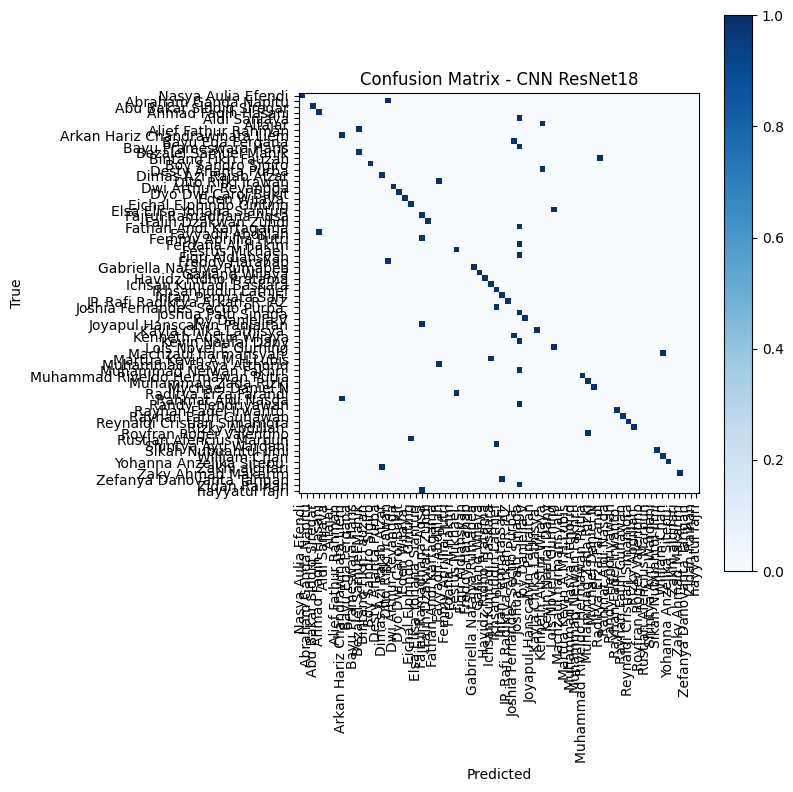

=== ViT small ===
                                 precision    recall  f1-score   support

             Nasya Aulia Efendi     0.0000    0.0000    0.0000         1
           Abraham Ganda Napitu     0.0000    0.0000    0.0000         1
       Abu Bakar Siddiq Siregar     1.0000    1.0000    1.0000         1
             Ahmad Faqih Hasani     0.3333    1.0000    0.5000         1
                   Aldi Sanjaya     0.0000    0.0000    0.0000         1
                        Alfajar     1.0000    1.0000    1.0000         1
            Alief Fathur Rahman     0.0000    0.0000    0.0000         1
 Arkan Hariz Chandrawinata Liem     1.0000    1.0000    1.0000         1
               Bayu Ega Ferdana     0.0000    0.0000    0.0000         1
          Bayu Prameswara Haris     0.0000    0.0000    0.0000         1
           Bezalel Samuel Manik     1.0000    1.0000    1.0000         1
           Bintang Fikri Fauzan     0.0000    0.0000    0.0000         1
              Boy Sandro Sigiro 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


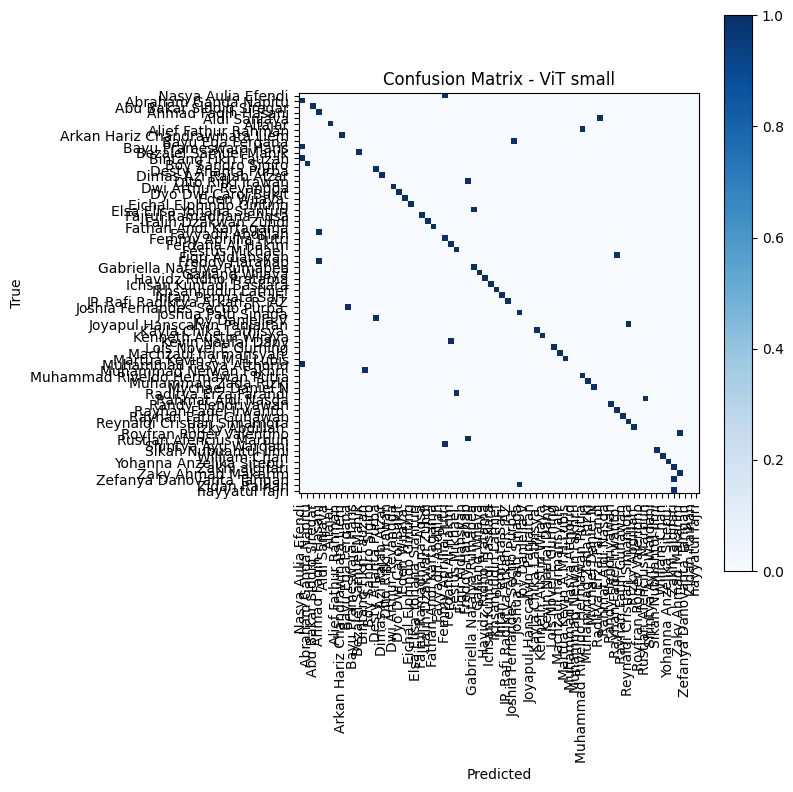

In [20]:

############################################################
# 8) EVALUASI DI VALIDATION SET (CONFUSION MATRIX)
############################################################

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, name="model"):
    model = model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print(f"=== {name} ===")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(cnn_model, val_loader, name="CNN ResNet18")
evaluate_model(vit_model, val_loader, name="ViT small")


############################################################
# 9) INFERENSI DENGAN MODEL TERLATIH
############################################################

Bagian ini memungkinkan Anda mengunggah gambar wajah dan mendapatkan prediksi dari model CNN (ResNet18) dan ViT (Vision Transformer) yang telah dilatih.

In [21]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import timm
import os
from pathlib import Path

# Pastikan device sudah terdefinisi dari setup awal
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ukuran gambar yang sama dengan saat training
IMG_SIZE = 224

# Transformasi untuk gambar inferensi (harus sama dengan val_transform)
inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def load_model_and_classes(model_path, model_arch_name, num_classes):
    """Memuat model dan daftar nama kelas dari file .pth"""
    checkpoint = torch.load(model_path, map_location=device)
    model = timm.create_model(model_arch_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    class_names = checkpoint["class_names"]
    return model, class_names

def preprocess_image(image_path):
    """Memproses gambar untuk input model"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = inference_transform(img)
    return img_tensor.unsqueeze(0) # Tambah batch dimension

In [22]:
print("Memuat model CNN ResNet18...")
cnn_model, class_names_cnn = load_model_and_classes(
    "cnn_resnet18_best.pth",
    "resnet18",
    len(class_names) # Menggunakan num_classes yang sudah ada atau bisa dari len(class_names_cnn)
)

print("Memuat model ViT small...")
vit_model, class_names_vit = load_model_and_classes(
    "vit_small_best.pth",
    "vit_small_patch16_224",
    len(class_names) # Menggunakan num_classes yang sudah ada atau bisa dari len(class_names_vit)
)

# Pastikan nama kelas sama antar model
if class_names_cnn != class_names_vit:
    print("Peringatan: Nama kelas tidak konsisten antar model.")
class_names = class_names_cnn

print("Model berhasil dimuat.")

Memuat model CNN ResNet18...
Memuat model ViT small...
Model berhasil dimuat.


In [23]:
def predict_uploaded_image(image_path):
    """Melakukan prediksi menggunakan ensemble dari CNN dan ViT"""
    img_tensor = preprocess_image(image_path).to(device)

    with torch.no_grad():
        # Prediksi dari CNN
        cnn_output = cnn_model(img_tensor)
        cnn_probs = F.softmax(cnn_output, dim=1)

        # Prediksi dari ViT
        vit_output = vit_model(img_tensor)
        vit_probs = F.softmax(vit_output, dim=1)

        # Ensemble (rata-rata probabilitas)
        ensemble_probs = (cnn_probs + vit_probs) / 2
        _, predicted_idx = torch.max(ensemble_probs, 1)

    return class_names[predicted_idx.item()]

In [24]:
import ipywidgets as widgets
from IPython.display import display, Image as DisplayImage
import io

print("Silakan unggah gambar wajah untuk ditebak:")

upload_widget = widgets.FileUpload(
    accept='image/*',  # Tipe file yang diterima
    multiple=False  # Hanya izinkan satu file untuk diunggah
)

output_widget = widgets.Output()

def on_upload_change(change):
    with output_widget:
        output_widget.clear_output()
        if not upload_widget.value:
            print("Tidak ada file yang diunggah.")
            return

        uploaded_filename = next(iter(upload_widget.value))
        uploaded_file_content = upload_widget.value[uploaded_filename]['content']

        # Simpan gambar yang diunggah ke file sementara
        temp_img_path = Path("uploaded_image.jpg")
        with open(temp_img_path, 'wb') as f:
            f.write(uploaded_file_content)

        print(f"File berhasil diunggah: {uploaded_filename}")

        # Tampilkan gambar yang diunggah
        display(DisplayImage(filename=temp_img_path.as_posix(), width=224, height=224))

        # Lakukan prediksi
        try:
            predicted_person = predict_uploaded_image(temp_img_path)
            print(f"Wajah terdeteksi: {predicted_person}")
        except Exception as e:
            print(f"Gagal melakukan prediksi: {e}")

        # Hapus file sementara
        temp_img_path.unlink(missing_ok=True)

upload_widget.observe(on_upload_change, names='value')

display(upload_widget, output_widget)

Silakan unggah gambar wajah untuk ditebak:


FileUpload(value={}, accept='image/*', description='Upload')

Output()